In [1]:
# Load libraries
import sqlite3 # sql querying
import numpy as np # linear algebra
import pandas as pd # data processing and wrangling
import os # facilitates interaction with underlying operating system
import seaborn as sns # data visualisation 
import matplotlib.pyplot as plt # further data visualisation 

# Some quick Pandas configuration:
pd.set_option('display.max_colwidth', None)  # Ensures full column content is shown
pd.set_option('display.max_columns', None)   # Ensures all columns are shown

# Some quick Seaborn configuration:
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")

# Now we will load the dataset put it into an SQL database and then query it using sqlite3:
# load dataset
df = pd.read_csv('/kaggle/input/indian-marriage-and-divorce-dataset/marriage_divorce_india_with_id.csv')

# Create SQLite database
conn = sqlite3.connect('example.db')

# Save dataset as a table
df.to_sql('indian_marriage_divorce', conn, if_exists='replace', index=False)

# enable SQL Magic
%reload_ext sql

# connect to sqliite database
%sql sqlite:///example.db

In [2]:
# First lets find out the length of the dataset:
total_rows_query = """
                SELECT COUNT(*) AS total_rows
                FROM indian_marriage_divorce;
                """
row_count = pd.read_sql_query(total_rows_query, conn)
print(f"The table contains {row_count.iloc[0,0]} rows.")

# Lets also print the size of the dataset:
file_path = "/kaggle/input/indian-marriage-and-divorce-dataset/marriage_divorce_india_with_id.csv"
file_size = os.path.getsize(file_path)
print(f"The dataset is {file_size/1000} MB.")

The table contains 1200 rows.
The dataset is 72.134 MB.


Let's bring in the dataset, and see what variables it captures:

In [3]:
full_table_query = """
            SELECT * 
            FROM indian_marriage_divorce 
            ORDER BY "Income Level (INR per month)" ASC;
            """
full_table = pd.read_sql_query(full_table_query, conn)
full_table

,Unique ID,Marriage Duration (Years),Age at Marriage,Marriage Type,Education Level,Income Level (INR per month),Caste/Religion,Urban/Rural,Family Involvement,Children,Divorce Status
0,MD522,37,30,Arranged,No Education,5287,Jain,Urban,Low,1,Yes
1,MD549,1,19,Love,Postgraduate,5320,Christian,Rural,Moderate,2,Yes
2,MD872,1,25,Arranged,Secondary,5390,Other,Rural,Low,4,Yes
3,MD900,25,34,Love,Postgraduate,5507,Jain,Urban,Low,1,No
4,MD1012,26,34,Arranged,Secondary,5924,Jain,Urban,Low,0,No
...,...,...,...,...,...,...,...,...,...,...,...
1195,MD614,18,27,Arranged,Primary,199549,Jain,Urban,Moderate,0,No
1196,MD1161,1,24,Love,No Education,199795,Sikh,Urban,Moderate,4,No
1197,MD366,9,18,Love,Postgraduate,199840,Hindu,Urban,Moderate,0,No
1198,MD973,9,19,Love,Primary,199923,Christian,Rural,High,4,Yes


# Exploratory Data Analysis (EDA):
Let's get a feel for this dataset, what does it contain? Knowing this we can begin to structure the questions that we can ask of it. This will facilitate efficient analysis. 

Whilst the columns with continious data like *Income*,*Age at Marriage*, and *Marriage Duration* are quick to understand. It would be prudent to understand the **unique** values contained in other feature columns such as *Eductation* etc. So we will be looking into what these are and the distribution of the data.

In [4]:
# Unique values query
unique_categorical_query = """
    SELECT 
        REPLACE(GROUP_CONCAT(DISTINCT "Marriage Type"), ',', ', ') AS Marriage_Type,
        REPLACE(GROUP_CONCAT(DISTINCT "Education Level"), ',', ', ') AS Education_Level,
        REPLACE(GROUP_CONCAT(DISTINCT "Caste/Religion"), ',', ', ') AS Caste_Religion,
        REPLACE(GROUP_CONCAT(DISTINCT "Urban/Rural"), ',', ', ') AS Urban_Rural,
        REPLACE(GROUP_CONCAT(DISTINCT "Family Involvement"), ',', ', ') AS Family_Involvement,
        REPLACE(GROUP_CONCAT(DISTINCT "Divorce Status"), ',', ', ') AS Divorce_Status
    FROM indian_marriage_divorce;
                            """

unique_categorical_table = pd.read_sql_query(unique_categorical_query, conn)
unique_categorical_table.T

,0
Marriage_Type,"Love, Arranged"
Education_Level,"Secondary, No Education, Postgraduate, Graduate, Primary"
Caste_Religion,"Hindu, Jain, Muslim, Christian, Other, Sikh"
Urban_Rural,"Rural, Urban"
Family_Involvement,"Moderate, High, Low"
Divorce_Status,"No, Yes"


In [5]:
# Columns of interest: Marriage Duration (Years), Age at Marriage, Income Level (INR per month), Children
quantitative_query = """
    SELECT 
        "Marriage Duration (Years)", 
        "Age at Marriage", 
        "Income Level (INR per month)",
        "Children"
    FROM indian_marriage_divorce;  
                    """
quantitative_table = pd.read_sql_query(quantitative_query, conn)

# Get descriptive statistics:
quantitative_ds_table = quantitative_table.describe()

# Calculate IQR and add it to the table:
iqr_values = [] # Create an empty IQR list to store the values
# Loop through the cols calculating the IQR for each col and storing it in the list.
for col in quantitative_table:
    q1 = quantitative_table[col].quantile(0.25)
    q3 = quantitative_table[col].quantile(0.75)
    iqr = q3-q1
    iqr_values.append(iqr)
# Insert the IQR values into the table:
quantitative_ds_table.loc["iqr"] = iqr_values
quantitative_ds_table

,Marriage Duration (Years),Age at Marriage,Income Level (INR per month),Children
count,1200.000000,1200.000000,1200.00000,1200.000000
mean,20.553333,26.055000,102353.21250,1.885833
std,11.468512,4.891003,55761.10746,1.453580
min,1.000000,18.000000,5287.00000,0.000000
25%,10.000000,22.000000,54522.00000,1.000000
50%,22.000000,26.000000,101888.50000,2.000000
75%,30.000000,30.000000,150568.75000,3.000000
max,39.000000,34.000000,199999.00000,4.000000
iqr,20.000000,8.000000,96046.75000,2.000000


One quick point of interest would be to see whether the type of marriage, arranged or out of love, affects the likelihood of divorce. 

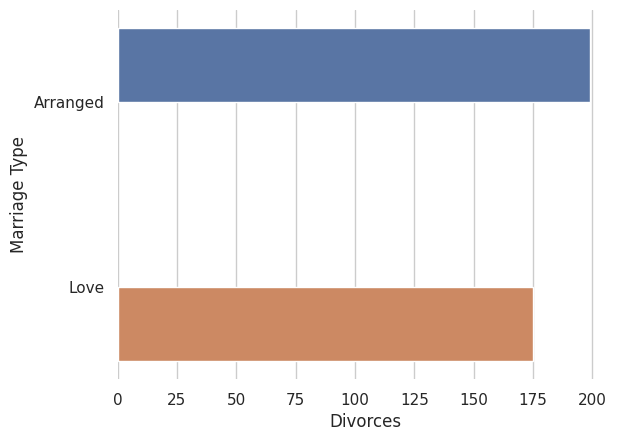

In [6]:
marriage_type_agg_query = """
                        SELECT 
                            "Marriage Type",
                            COUNT("Divorce Status") as Divorces
                        FROM 
                            indian_marriage_divorce
                        WHERE "Divorce Status" LIKE "Yes"
                        GROUP BY "Marriage Type";
                        """
marriage_type_agg_table = pd.read_sql_query(marriage_type_agg_query, conn)
marriage_type_agg_table
# Plot the total divorces
sns.barplot(y="Marriage Type", x="Divorces", data=marriage_type_agg_table,
            hue="Marriage Type")
sns.despine(left=True, bottom=True)
plt.legend([], [], frameon=False);


# Linear Regressions:

In [7]:
# Divorce and Age at Marriage

In [8]:
# Divorce and Marriage Duration

In [9]:
# Divorce and Income

In [10]:
# Divorce and No. Children

# Logistic Regression?